In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
IPython.display.Audio("ibeep.mp3",autoplay=True)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
from sindy_functions import *
from systems import *

In [5]:
#sr3 trimming problem

In [6]:
#Bearing outer race fault - like signal generator

def ims_det(tlim,dt=1/20480,ff=1/200,m=1,k=1e9,c=2e3,famp=1,fsqr=2):
    
    """
    Bearing outer race fault - like signal generator
    
    Inputs: (tlim, dt=0.01, ff=5, m=1, k=1000, c=10, iscale=1)
    Retruns: (time stamps, actual system state, system & signal properties)
    """
    
    def F(t):
        r=-np.exp(-np.abs(((t%(ff)-(2e-4))*2e4))**fsqr)*famp
        return r
    
    mkc=tuple([m,k,c])
    
    def smd(x,t,m,k,c):
        dx=[x[1],
            F(t)/m-(k*x[0]+c*x[1])/m]
        return dx

    tstamps=np.arange(0,tlim,dt)
    x0=[0,0]
    
    sol=sc.integrate.odeint(smd,x0,tstamps,args=mkc,rtol=1e-12,atol=1e-12)
    Sol=sol.T
    
    return tstamps, Sol, (dt,ff,m,k,c)

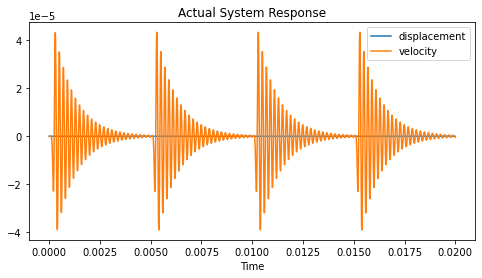

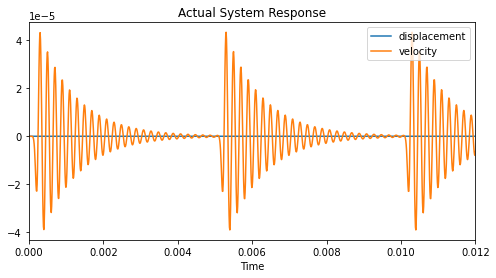

initial variable normalisation constants (division): [1.53559087e-09 4.33505370e-05]
variable normalisation constants (division): [1.55822023e-09 4.39782109e-05]


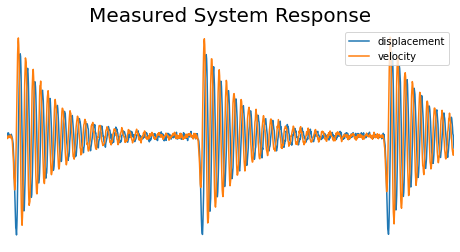

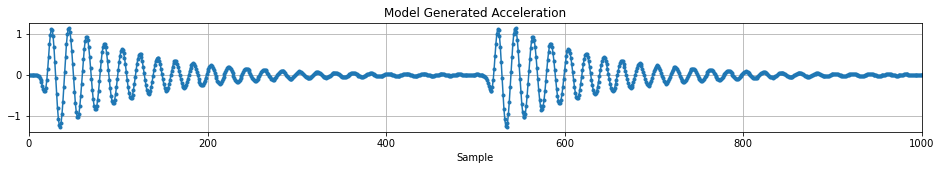

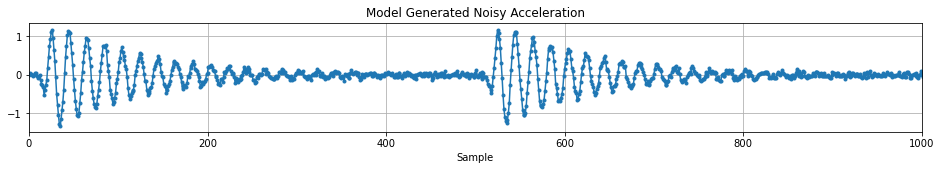

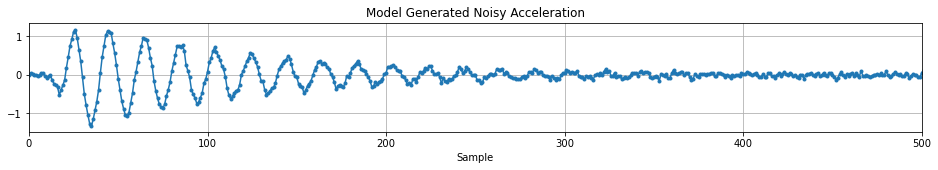

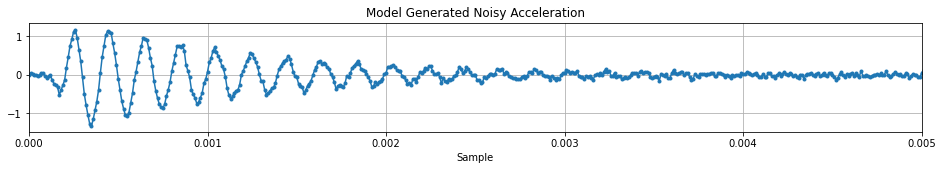

In [7]:
stlim=0.02
tstamps,Sol,_=ims_det(stlim,ff=1/200,dt=1e-5,famp=1,fsqr=2)
dt=_[0]
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T
sf=1/dt

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
#midpoint=np.array([0,0])
Solm=Sol-np.reshape(midpoint,(2,-1))

#Sol[1]=np.gradient(Sol[0],dt)

#Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
#Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

plt.figure(figsize=(8, 4))
plt.title('Actual System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='displacement')
plt.plot(tstamps,Sol[1,:],label='velocity')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Actual System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='displacement')
plt.plot(tstamps,Sol[1,:],label='velocity')
plt.xlim([0,0.012])
plt.legend()
plt.show()

#x, x' normalisation - noise free

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
Solm=Sol-np.reshape(midpoint,(2,-1))

nc=np.abs(Solm.T).max(axis=0)
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T

nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

#noise addition
np.random.seed(0) #seed 0 M4,4 M10
nlevel=0.03
nSol=np.random.normal(nSol,nlevel/2)
#nSol=nSol+np.random.uniform(low=-0.1,high=0.1,size=nSol.shape)
#nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
#nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[0]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

#x, x' normalisation - with noise

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2*0
uSolm=uSol-np.reshape(midpoint,(2,-1))*0

nc=np.abs(uSolm.T).max(axis=0)
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

plt.figure(figsize=(8, 4))
plt.title('Measured System Response',fontsize=20)
plt.xlabel('Time')
plt.plot(tstamps,nSol[0,:],label='displacement')
plt.plot(tstamps,nSol[1,:],label='velocity')
plt.xlim([0,0.012])
plt.legend()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(16,2))
plt.title('Model Generated Acceleration')
plt.xlabel('Sample')
plt.plot(np.gradient(Sol[1,:],dt),'.-',label='acc')
plt.xlim(0,1000)
plt.grid()
plt.show()

plt.figure(figsize=(16,2))
plt.title('Model Generated Noisy Acceleration')
plt.xlabel('Sample')
plt.plot(np.gradient(uSol[1,:],dt),'.-',label='acc')
plt.xlim(0,1000)
plt.grid()
plt.show()

plt.figure(figsize=(16,2))
plt.title('Model Generated Noisy Acceleration')
plt.xlabel('Sample')
plt.plot(np.gradient(uSol[1,:],dt),'.-',label='acc')
plt.xlim(0,500)
plt.grid()
plt.show()

plt.figure(figsize=(16,2))
plt.title('Model Generated Noisy Acceleration')
plt.xlabel('Sample')
plt.plot(tstamps,np.gradient(uSol[1,:],dt),'.-',label='acc')
plt.xlim(0,0.005)
plt.grid()
plt.show()

In [8]:
#feature_library=poly_library
deg=3
poly_library=ps.PolynomialLibrary(deg)

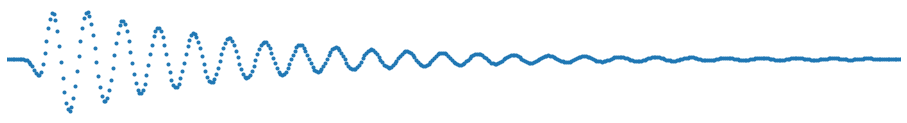

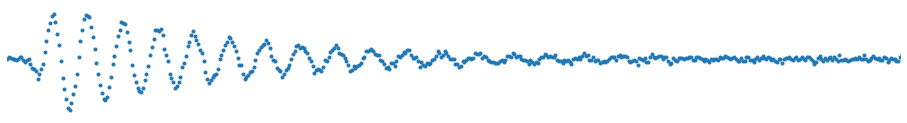

In [9]:
plt.figure(figsize=(16,2))
plt.xlabel('Sample')
plt.plot(np.gradient(Sol[1,:],dt),'.',label='acc')
plt.xlim(0,500)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(16,2))
plt.xlabel('Sample')
plt.plot(np.gradient(nSol[1,:],dt),'.',label='acc')
plt.xlim(0,500)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
#no noise

# Without trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', max_iter=300)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,:].T, t=dt, quiet=True)
print("Without trimming")
model.print()

Without trimming
(x0)' = 27771.377 x1
(x1)' = -35417.569 x0 + -4944.260 x0^2 + -6882.664 x0 x1 + 5965.568 x0^3 + 9605.667 x0^2 x1 + 10055.227 x0 x1^2 + -3269.765 x1^3


In [11]:
#noisy

# Without trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l1', max_iter=300)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,:].T, t=dt, quiet=True)
print("Without trimming")
model.print()

Without trimming
(x0)' = 27731.852 x1
(x1)' = -35011.684 x0 + -4870.143 x0^2 + -7358.275 x0 x1 + 5476.953 x0^3 + 10461.143 x0^2 x1 + 10510.642 x0 x1^2 + -3677.891 x1^3


In [12]:
#if cropped manually

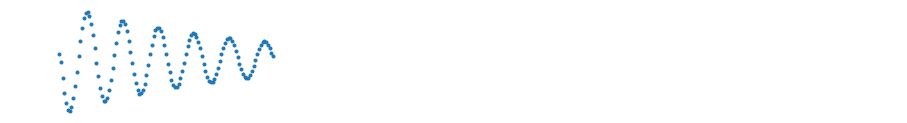

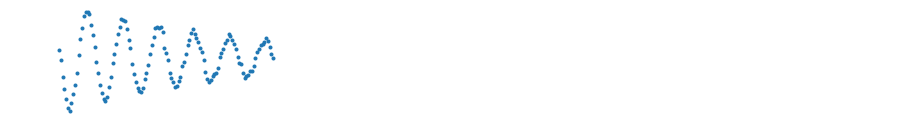

In [13]:
plt.figure(figsize=(16,2))
plt.xlabel('Sample')
plt.plot(tstamps[int(3e-4/dt):int(1.5e-3/dt)],np.gradient(Sol[1,int(3e-4/dt):int(1.5e-3/dt)],dt),'.',label='acc')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(16,2))
plt.xlabel('Sample')
plt.plot(tstamps[int(3e-4/dt):int(1.5e-3/dt)],np.gradient(nSol[1,int(3e-4/dt):int(1.5e-3/dt)],dt),'.',label='acc')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
#no noise

# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', max_iter=300)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,int(3e-4/dt):int(1.5e-3/dt)].T, t=dt, quiet=True)
print("With manual trimming")
model.print()

With manual trimming
(x0)' = 27825.191 x1
(x1)' = -34832.893 x0 + -1993.677 x1


In [15]:
#noisy

# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', max_iter=300)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,int(3e-4/dt):int(1.5e-3/dt)].T, t=dt, quiet=True)
print("With manual trimming (l0)")
model.print()

With manual trimming (l0)
(x0)' = 27798.441 x1 + -1045.106 x0^2 x1 + -2475.738 x0 x1^2
(x1)' = -34990.454 x0 + -1667.608 x1 + -1627.820 x0 x1 + 1841.512 x0 x1^2


In [16]:
#noisy 

# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l1', max_iter=300)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,int(3e-4/dt):int(1.5e-3/dt)].T, t=dt, quiet=True)
print("With manual trimming (l1)")
model.print()

With manual trimming (l1)
(x0)' = 27693.458 x1
(x1)' = -34744.662 x0 + -1700.206 x1


In [20]:
# just making sure stcv isn't struggling
deg=3
mc,icv=SINDyCV_t_1(polypool(nSol[:,int(3e-4/dt):int(1.5e-3/dt)].T,deg),nSoldt[:,int(3e-4/dt):int(1.5e-3/dt)].T,0.01,1e-1,1e-16,0.0,100,ptf=0.3,normalise='auto',reticv=True)
names=polypool_names(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)
np.round(icv,2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  0.  ,   0.  ],
       [  0.  , -11.54],
       [ 11.19,  -0.68],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ]])

In [21]:
#theoretical
nc[1]/nc[0],-1e9/(nc[1]/nc[0]),-2e3

(28223.360234130563, -35431.642146943865, -2000.0)

In [22]:
#noisy 

# Without trimming - just playing with ssr
sr3_optimizer = ps.SSR()
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,int(3e-4/dt):int(1.5e-3/dt)].T, t=dt, quiet=True)
print("Without trimming")
model.print()

Without trimming
(x0)' = -16.003 1 + 92.300 x0 + 27671.914 x1 + 23.922 x0^2 + -160.069 x0 x1 + 133.874 x1^2 + -15.022 x0^3 + 203.661 x0^2 x1 + -586.474 x0 x1^2 + 288.012 x1^3
(x1)' = 24.121 1 + -34858.263 x0 + -1823.435 x1 + -35.999 x0^2 + 60.452 x0 x1 + -144.217 x1^2 + 2.586 x0^3 + -137.045 x0^2 x1 + 216.581 x0 x1^2 + -339.293 x1^3


In [24]:
#1- no noise filtering better data


With trimming
(x0)' = 27771.377 x1
(x1)' = -30827.120 x0 + 0.046 x1


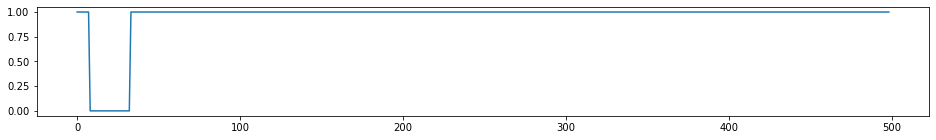

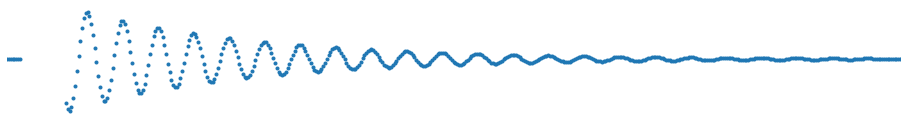

In [25]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.05, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSolnf[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()


With trimming
(x0)' = 27771.377 x1
(x1)' = -35474.408 x0 + -1427.537 x1 + -5021.893 x0^2 + -6877.700 x0 x1 + 5925.332 x0^3 + 10505.050 x0^2 x1 + 10848.289 x0 x1^2


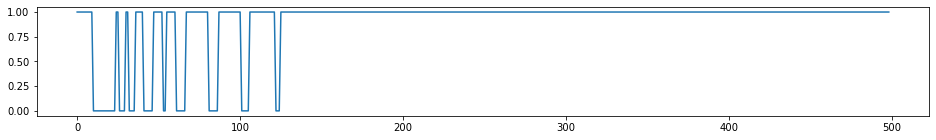

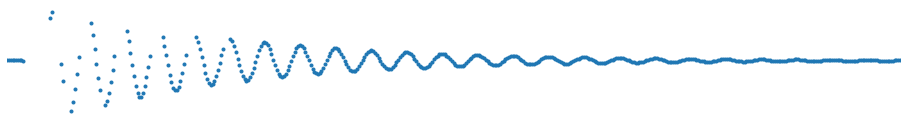

In [26]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.1, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSolnf[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()


With trimming
(x0)' = 27771.377 x1
(x1)' = -30827.120 x0 + 0.046 x1


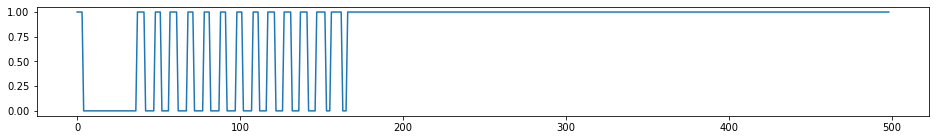

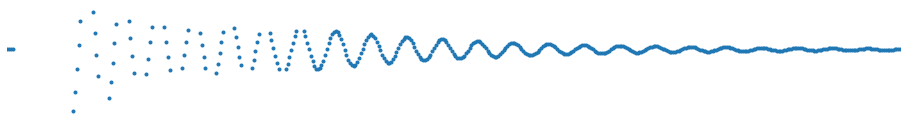

In [27]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.2, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSolnf[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()


With trimming
(x0)' = 27771.377 x1
(x1)' = -35417.569 x0 + -4944.260 x0^2 + -6882.664 x0 x1 + 5965.568 x0^3 + 9605.667 x0^2 x1 + 10055.227 x0 x1^2 + -3269.765 x1^3


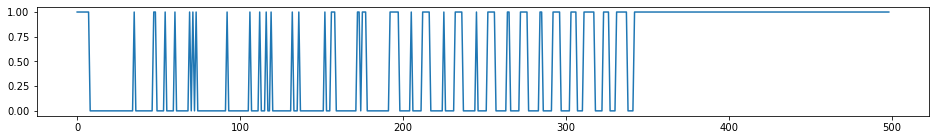

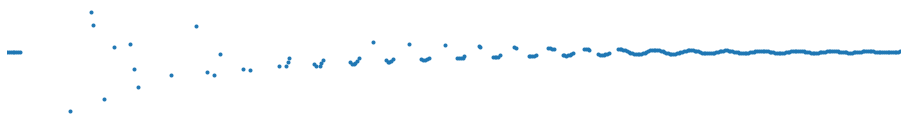

In [28]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.5, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSolnf[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSolnf[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
#2- noisy filtering random data with no model improvement


With trimming
(x0)' = 27731.852 x1
(x1)' = -30675.874 x0 + 9023.362 x0^2 x1


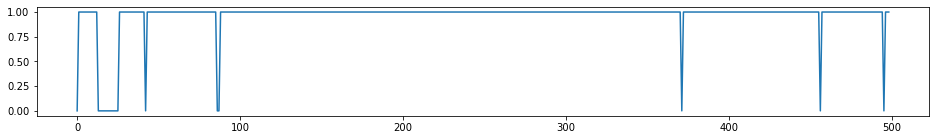

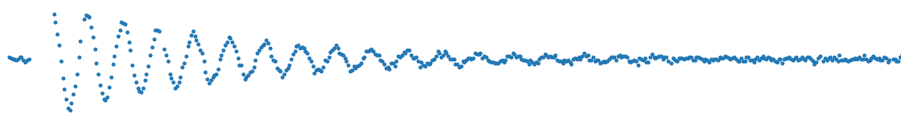

In [30]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.05, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSol[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()


With trimming
(x0)' = 27731.852 x1
(x1)' = -30673.717 x0 + -1694.963 x1 + 13995.881 x0^2 x1


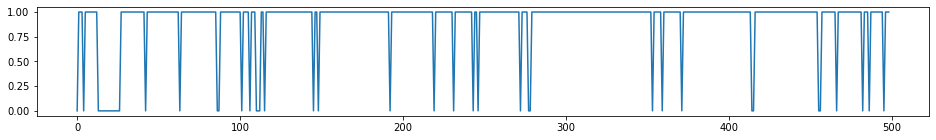

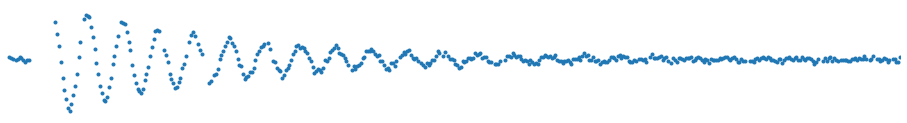

In [31]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.1, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSol[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()


With trimming
(x0)' = 27731.852 x1
(x1)' = -34341.684 x0 + 131.939 x1 + -5060.841 x0^2 + 4966.911 x0^3 + 7320.351 x0 x1^2


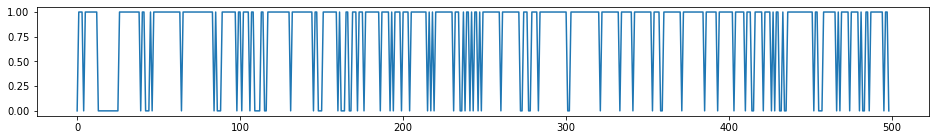

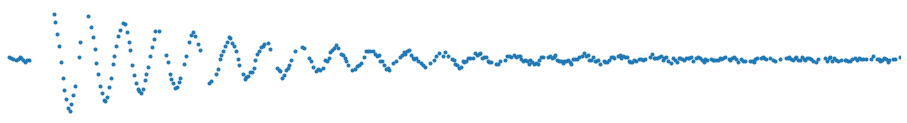

In [32]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l0', trimming_fraction=0.2, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSol[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()


With trimming
(x0)' = 27731.852 x1
(x1)' = -30677.218 x0 + 24.399 x1


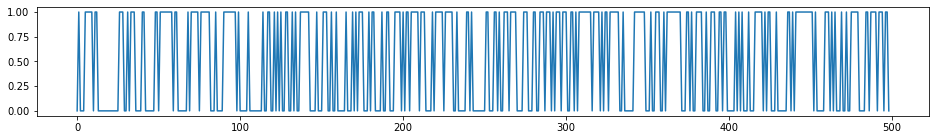

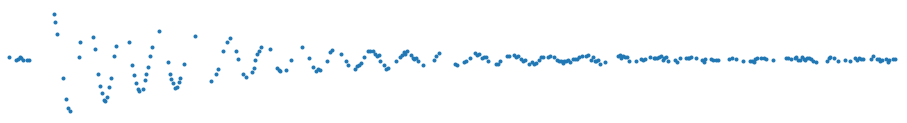

In [33]:
# With trimming
sr3_optimizer = ps.SR3(threshold=1500, thresholder='l1', trimming_fraction=0.5, max_iter=10000)
model = ps.SINDy(optimizer=sr3_optimizer,feature_library=poly_library).fit(nSol[:,:].T, t=dt, quiet=True)
print("\nWith trimming")
model.print()

plt.figure(figsize=(16,2))
plt.plot(model.optimizer.history_trimming_[-1][:int(5e-3/dt)])
plt.show()

plt.figure(figsize=(16,2))
plt.plot(tstamps[(model.optimizer.history_trimming_[-1])>0.5],
         np.gradient(nSol[1,:],dt)[(model.optimizer.history_trimming_[-1])>0.5],'.')
plt.xlim(0,5e-3)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()